# Distribution of fixation times with background selection

This example mixes the simulation of positive selection with strongly-deleterious mutations (background selection, or "BGS" for short).

The setup of the BGS model is the same as the other example.  This example adds the following:

1. Include a class of beneficial mutations ($s>0$) and fitnesses $1, 1+s, 1+2s$ for the three genotypes.
2. We will track the frequency trajectories of all selected mutations during every simulation
3. From those trajectories, we will get the fixation times of all beneficial mutations.
4. These fixation times will be recorded in a pandas DataFrame.

This is the really cool part:

5. We will send that DataFrame to R for plotting using ggplot.

In [1]:
%load_ext rpy2.ipython

In [2]:
import fwdpy as fp
import numpy as np
import pandas as pd

Our simulation is set up in the same manner that Hudson, Kaplan, and colleagues used to study the structured coalescent:

1. Our locus of interest has mutations occurring along the interval $[0,1)$.
2. That locus is flanked by loci where mutations causing BGS occur.

The relevant details here are:

1. We will simulate no neutral variants.
2. Our positively-selected variants will occur in the "locus" of interest.
3. Recombination will take place as a uniform process across all regions.

In [3]:
#We will simulate no neutral mutations
nregions = []

#These are our "BGS loci"
sregions = [fp.ConstantS(beg=-1,end=0,weight=1,s=-0.05,h=1),
            fp.ConstantS(beg=1,end=2,weight=1,s=-0.05,h=1)]
           
#Recombination is uniform across whole region
recregions = [fp.Region(beg=-1,end=2,weight=1)]

#Population size
N=1000
##Evolve for 20N generations with constant N
nlist = np.array([N]*20*N,dtype=np.uint32)

#Random number generator
rng = fp.GSLrng(101)

We need to define a function to go from trajectories of selected mutations to lists of fixation times.  This function is trivial with Python's "list comprehensions":

In [4]:
def get_fixation_times(trajectories):
    """
    Takes a set of trajectories, creates a list of fixation times, which is
    returned.
    
    The elements in trajectories are a list, with element 0 a 'dict' containing
    info about each variant, and element 1 being a list of frequencies over time.
    """
    if len(trajectories.index)==0:
        return []
    groups=trajectories.groupby(['pos','esize','origin'])
    for n,g in groups:
        if g.freq.max() < 1.:
            raise RuntimeError("this group is not a fixation")
    return [len(g.index) for n,g in groups]
    #return[len(i[1]) for i in trajectories if max(i[1])==1 and i[0][b'esize']>0]

Now, run the simulation itself.

_Note:_  I'm only doing 40 replicates for each $s$, which is of course limiting.

This example runs in a few minutes on my machine.

In [5]:
#This will be our range of selection coefficients
svals=[1e-3,1e-2,5e-2,1e-1]

#This will be our number of populations/replicates
NPOPS=40

#A list to collect our intermediate pandas DataFrames
df=[]

for s in svals:
        #Copy sregions from above
        sregions_current=sregions
        #Add a new region with +ve-ly selected variants.
        #NEED TO ADD A COMMENT ABOUT WHAT THE WEIGHT HERE MEANS
        sregions_current.append(fp.ConstantS(beg=0,end=1,weight=1e-3,s=s,h=1))
        #Create a vector of 40 pops.
        #This means that fwdpy will use 40 threads to simulate the 40 replicates.
        pops = fp.SpopVec(NPOPS,N)
        sampler=fp.FreqSampler(len(pops))
        traj = fp.evolve_regions_sampler(rng,       
                                        pops,         
                                        sampler,
                                        nlist[0:], #List of population sizes over time.
                                        0.0,     #Neutral mutation rate = 0 (per gamete, per generation)
                                        0.001,      #Mutation rate to selected variants(per gamete, per generation)
                                        0.005,     #Recombination rate (per diploid, per generation)
                                        nregions,  #Defined above
                                        sregions_current,  #Defined above
                                        recregions,  #Defined above
                                        1)#update mutation frequency trajectories every generation
        #We now have a list of trajectory objects,
        #and our task is to collect the fixations from
        #them.
        raw_ftimes = [get_fixation_times(sampler.fetch(i,freq_filter = lambda x : x[-1][1]==1. )) for i in range(len(sampler))]
        for i in raw_ftimes:
            #Create a pandas DataFrame
            if len(i)>0:
                df.append(pd.DataFrame({'s':[s]*len(i),'ftimes':i}))
        
#catenate all the DataFrames, and we'll send them to R for plotting.
dataForR=pd.concat(df)

In [6]:
%R require(ggplot2)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


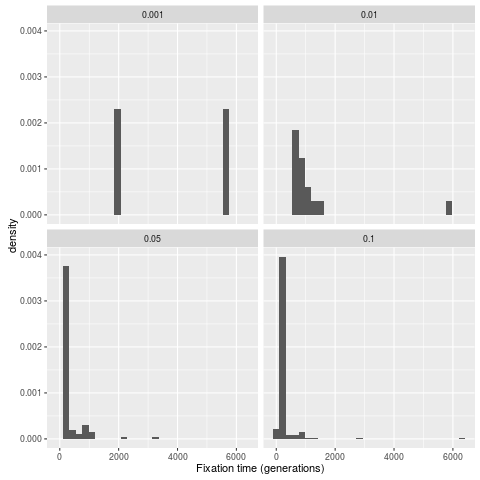

In [7]:
%%R -i dataForR
p = ggplot(dataForR,aes(x=ftimes,y=..density..)) + 
geom_histogram() +  
facet_wrap( ~s,nrow=2) + 
xlab("Fixation time (generations)")
print(p)

In [8]:
#Take a look at the mean time to fixation
dataForR.groupby(['s']).mean()

,ftimes
s,
0.001,3834.000000
0.010,1221.666667
0.050,377.150538
0.100,259.683168
